In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals, rms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import nglview as nv
import pandas
import math
from openmm import *

### Set parameters 

In [2]:
is_deactivate_warning = True
is_savefigs = True
is_makemovie = False
is_makemovie_from_disk = False

sysname = 'AlanineDipeptide'
# name of PDB file
pdb_filename = "./vacuum.pdb"
# name of DCD file
output_path = './traj_data' 

traj_dcd_filename = '%s/traj.dcd' % output_path
traj_bias_filename = '%s/BIAS' % output_path

if is_deactivate_warning :
    import warnings
    warnings.filterwarnings("ignore")    
    
if is_makemovie :
    import moviepy.editor as mpy
    from time import sleep
    # display the gif in this notebook
    from IPython import display

### Load trajectory data 

In [3]:
# load the trajectory data from DCD file
u = mda.Universe(pdb_filename, traj_dcd_filename)
# load the reference configuration from the PDB file
ref = mda.Universe(pdb_filename) 

# print some information
print ('residues: ', u.residues)
print ('trajectory: ', u.trajectory)
print ('reference: ', ref.trajectory)

# display the trajectory
view = nv.show_mdanalysis(u)
print ('number of frames: %d ' % view.max_frame)
view

residues:  <ResidueGroup [<Residue ACE, 1>, <Residue ALA, 2>, <Residue NME, 3>]>
trajectory:  <DCDReader ./traj_data/traj.dcd with 1000 frames of 22 atoms>
reference:  <PDBReader ./vacuum.pdb with 1 frames of 22 atoms>
number of frames: 999 


NGLWidget(max_frame=999)

### Generate plots of two dihedral angles

Ramachandran plot saved to file: ././traj_data/AlanineDipeptide_Ramachandran.eps


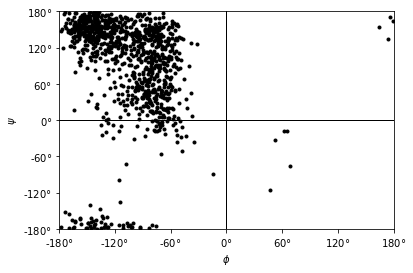

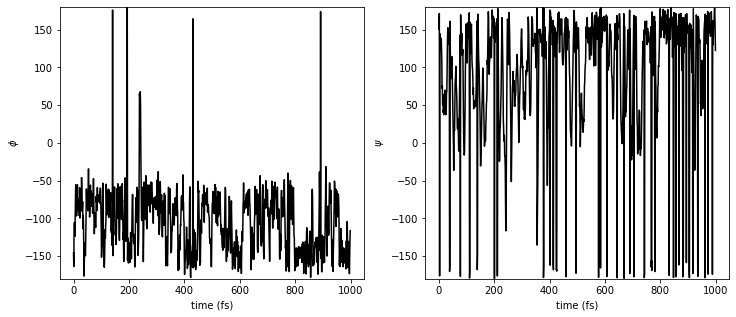

In [4]:
# generate the Ramachandran plot of two dihedral angles
ax = plt.gca()
r = dihedrals.Ramachandran(u.select_atoms('resid 2')).run()
r.plot(ax, color='black', marker='.') #, ref=True)

traj_angles = r.angles[:,0,:]

if is_savefigs :
    fig_filename_Ramachandran = './%s/%s_Ramachandran.eps' % (output_path, sysname)
    plt.savefig(fig_filename_Ramachandran)
    print ('Ramachandran plot saved to file: %s' % fig_filename_Ramachandran)
    
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(traj_angles[:,0], 'k-')
ax[0].set_ylim([-180,180])
ax[0].set_xlabel("time (fs)")
ax[0].set_ylabel(r"$\phi$")

ax[1].plot(traj_angles[:,1], 'k-')
ax[1].set_xlabel("time (fs)")
ax[1].set_ylim([-180,180])
ax[1].set_ylabel(r"$\psi$")

plt.show()

### Plot weights

Index(['Time (ps)', 'weight'], dtype='object')

Describe:
 count    1.000000e+03
mean     1.000000e+00
std      2.728271e+01
min      8.314827e-15
20%      1.367920e-08
40%      1.357775e-06
50%      5.670315e-06
60%      3.132308e-05
80%      1.484198e-03
max      8.612031e+02
Name: weight, dtype: float64

Describe:
 count    8.030000e+02
mean     1.624483e-02
std      7.159849e-02
min      1.001024e-08
20%      4.700881e-07
40%      6.222325e-06
50%      2.117145e-05
60%      1.030314e-04
80%      2.186417e-03
max      7.942455e-01
Name: weight, dtype: float64


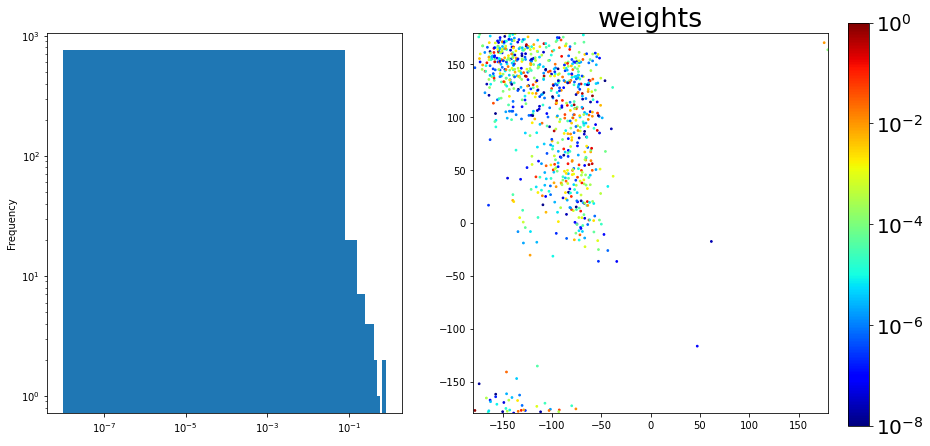

In [9]:
weight_filename = "%s/weights.csv" % output_path
weights = pandas.read_csv(weight_filename)
print (weights.columns)
print ('\nDescribe:\n', weights['weight'].describe(percentiles=[0.2, 0.4, 0.6, 0.8]))
fig, ax = plt.subplots(1,2, figsize=(14,7))

nbin=10
[vmin, vmax] = [1e-8, 1e0]
[min_weight, max_weight] = [1e-8, 1e0]

select = (weights['weight']>min_weight) & (weights['weight']<max_weight)
weights = weights[select]
print ('\nDescribe:\n', weights['weight'].describe(percentiles=[0.2, 0.4, 0.6, 0.8]))

weights['weight'].plot(kind='hist', logx=True, logy=True, ax=ax[0], bins=nbin)

sc = ax[1].scatter(traj_angles[select,0], traj_angles[select,1], s=3.0, c=weights['weight'], vmin=vmin, vmax=vmax, cmap='jet', norm=matplotlib.colors.LogNorm())

ax[1].set_title(f'weights', fontsize=27)
ax[1].set_xlim([-180,180])
ax[1].set_ylim([-180,180])

#ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
#ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
cax = fig.add_axes([0.92, 0.10, .02, 0.80])
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.tick_params(labelsize=20)

plt.show()

### RMSD plot

RMSD plot saved to file: ././traj_data/AlanineDipeptide_rmsd.eps


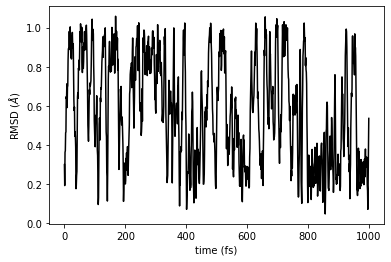

In [10]:
# select atoms for RMSD computation below 
selector = 'name N or name CA or name C'
# compute RMSD of the trajectory wrt the reference configuration
R = rms.RMSD(u, ref, select=selector)          
R.run()
# get the RMSD result
rmsd = R.results.rmsd.T   # transpose makes it easier for plotting

plt.plot(rmsd[0,:], rmsd[2,:], 'k-')
plt.xlabel("time (fs)")
plt.ylabel(r"RMSD ($\AA$)")

if is_savefigs :
    fig_filename_rmsd = './%s/%s_rmsd.eps' % (output_path, sysname) 
    plt.savefig(fig_filename_rmsd)    
    print ('RMSD plot saved to file: %s' % fig_filename_rmsd)

### Plot state data from CSV file

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Index(['#"Time (ps)"', 'Potential Energy (kJ/mole)', 'Total Energy (kJ/mole)',
       'Temperature (K)'],
      dtype='object')
Potential Energy saved to file: ././traj_data/AlanineDipeptide_csv1.eps


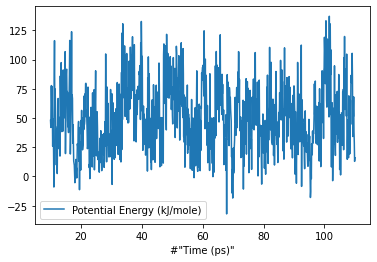

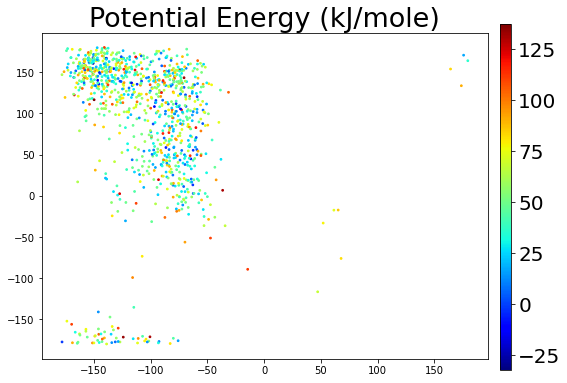

In [11]:
csv_filename = "%s/state_data.csv" % output_path
csv_col_idx = 1

df1 = pandas.read_csv(csv_filename)
print (df1.columns)
df1.plot(kind='line', x='#"Time (ps)"', y=df1.columns[csv_col_idx])

if is_savefigs :
    fig_filename= './%s/%s_csv%d.eps' % (output_path, sysname, csv_col_idx) 
    plt.savefig(fig_filename)    
    print ('Potential Energy saved to file: %s' % fig_filename)

fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(traj_angles[:,0], traj_angles[:,1], s=3.0, c=df1[df1.columns[csv_col_idx]], cmap='jet')

ax.set_title(f'{df1.columns[csv_col_idx]}', fontsize=27)
#ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
#ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])

cax = fig.add_axes([0.92, 0.10, .02, 0.80])
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.tick_params(labelsize=20)
plt.show()


### Make a movie out of trajectory data (experimental)